In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

In [3]:
sys.executable

'/Users/leevironty/koodi/kandi/venv/bin/python3'

In [4]:
from prophet.python import fbprophet
from prophet.python.fbprophet import models
from prophet.python.fbprophet import plot
from prophet.python.fbprophet import diagnostics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pkg_resources
import os
from pathlib import Path
import numpy as np
import scipy
from copy import deepcopy
import tqdm



Importing plotly failed. Interactive plots will not work.


In [5]:
features = pd.read_csv('data/Features data set.csv')
features['Date'] = pd.to_datetime(features['Date'], dayfirst=True)
sales = pd.read_csv('data/sales data-set.csv')
sales['Date'] = pd.to_datetime(sales['Date'], dayfirst=True)
stores = pd.read_csv('data/stores data-set.csv')

In [6]:
sales_weekly = sales.groupby(['Store', 'Date']).sum().reset_index().merge(stores, on='Store')[['Store', 'Date', 'Weekly_Sales', 'Type', 'Size']]

In [7]:
for i in features['Store'].unique():
    store_mask = features['Store'] == i
    store_features = features[store_mask]
    cp_flags = store_features['Unemployment'].diff() != 0
    store_features.loc[cp_flags, 'u_cp'] = store_features.loc[cp_flags, 'Unemployment']
    features.loc[store_mask, 'unemployment_interpolated'] = store_features['u_cp'].interpolate().values

/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/leevironty/koodi/kandi/venv/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
data = features.merge(sales_weekly, on=['Store', 'Date'])

In [9]:
def weighted_mean(chunk):
    fs = chunk[['Temperature', 'Fuel_Price', 'CPI', 'unemployment_interpolated', 'Weekly_Sales']]
    holidays = chunk['IsHoliday']
    is_holiday = holidays.sum() > 0
    scales = chunk['Size']
    weighted_features = (fs * scales.values[:, np.newaxis]).sum() / scales.sum()
    weighted_features['IsHoliday'] = is_holiday
    return weighted_features

In [10]:
def ar_noise(s, scale=0.05, fii=0.3):
    pass

In [11]:
def format_for_prophet(df):
    df = df.reset_index()
    df = df.rename(columns={'Date':'ds', 'Weekly_Sales':'y', 'Temperature':'temperature', 'Fuel_Price':'fuel_price', 'CPI':'cpi'})
    df['overfit'] = (df['y'] / df['y'].max()) + np.random.normal(loc=0, scale=0.01, size=df.shape[0])
    df['IsHoliday'] = df['IsHoliday'].astype(bool)
    return df

In [12]:
datasets = {}
for t, chunk in data.groupby('Type'):
    wm = chunk.groupby('Date').apply(weighted_mean)
    datasets[t] = format_for_prophet(wm)

In [13]:
data.head(4)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,unemployment_interpolated,Weekly_Sales,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,8.10600,1643690.90,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,8.06875,1641957.44,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,8.03150,1611968.17,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,7.99425,1409727.59,A,151315


In [14]:
datasets['A'].head(4)

,ds,temperature,fuel_price,cpi,unemployment_interpolated,y,IsHoliday,overfit
0,2010-02-05,33.690032,2.703840,170.722140,8.453469,1.576715e+06,False,0.616943
1,2010-02-12,32.856791,2.685976,170.819624,8.433678,1.516366e+06,True,0.596989
2,2010-02-19,36.120051,2.657191,170.866465,8.413886,1.518252e+06,False,0.586378
3,2010-02-26,38.431706,2.678402,170.904866,8.394094,1.370861e+06,False,0.523287


In [15]:
fit_kwargs = {'adapt_delta': 0.9, 'max_treedepth': 11, 'adapt_kappa': 0.75}

In [16]:
def lppd(model, s=None):
    
    return np.log(np.exp(model.params['log_lik']).mean(axis=0)).sum()


def aic(model):
    k = model.params['beta'].shape[1] + model.params['delta'].shape[1] + 2
    return -2*lppd(model) + 2*k


def log_lik_bayes_theta(model):
    mu = model.predict()['yhat']/model.y_scale
    y = model.history['y']/model.y_scale
    sigma = model.params['sigma_obs'].mean()
    return scipy.stats.norm.logpdf(y, loc=mu, scale=sigma).sum()


def dic(model):  # Vois olla nopeempi, nyt log_lik_bayes laskettu kahdesti
    return -2*log_lik_bayes_theta(model) + 2*p_dic(model)


def dic_alt(model):
    return -2*log_lik_bayes_theta(model) + 2*p_dic_alt(model)


def waic(model):
    #ll = model.params['log_lik']
    #pwaic2 = 1/(model.mcmc_samples - 1)*((ll - ll.mean(axis=0))**2).sum(axis=0).sum()
    return -2*lppd(model) + 2*p_waic_2(model)

def loo_cv(model):
    k = model.history.shape[0]
    return k_fold_loo_cv(model, k)

def k_fold_loo_cv(model, k=10):  # Oletetaan, että residuaalit iid
    og_lppd = lppd(model)
    data = model.history.sample(frac=1).reset_index(drop=True)  # shuffle
    breakpoints = np.linspace(0, data.shape[0], k+1, endpoint=True).astype(int)

    #scipy.stats.norm.pdf(p, loc=df['y'].values, scale=m1.params['sigma_obs'][:, np.newaxis])  # TODO: muista skaalaus
    def train_test_split(i):  # OK
        test = data[breakpoints[i]:breakpoints[i+1]].sort_values(by='t')#.reset_index().drop(columns='index')
        train = data.drop(test.index, axis=0).sort_values(by='t').reset_index(drop=True)
        test = test.reset_index(drop=True)
        return (train, test) 

    res = 0
    lppds = []
    params = []
    for i in range(k):
    #for i in tqdm.tqdm(range(k)):
        #print(f'CV {i}')
        train, test = train_test_split(i)
        clean_model = prophet_copy(model)
        fit = clean_model.fit(train, control=fit_kwargs)  # Voiko olla ongelma, että t scale muuttuu?
        params.append(fit.params.copy())
        p = predict_with_samples(fit, test)  
        lik = scipy.stats.norm.pdf(p/fit.y_scale, loc=test['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis]) # OK
        res += np.log(lik.prod(axis=1).mean())  # OK

        #p_i = predict_with_samples(fit, model.history)
        #b_lik = scipy.stats.norm.pdf(p_i/fit.y_scale, loc=model.history['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis])
        #lppd_i = np.log(b_lik.prod(axis=1).mean())
        #mean_lppd_i += np.log(b_lik.prod(axis=1).mean())/k  # Taitaa olla väärin
        lppd_i = 0
        for j in range(k):
            #print(f'lppd {j}')
            train_i, test_i = train_test_split(j)
            p_i = predict_with_samples(fit, test_i)
            lik_i = scipy.stats.norm.pdf(p_i/fit.y_scale, loc=test_i['y'].values/fit.y_scale, scale=fit.params['sigma_obs'][:, np.newaxis])
            lppd_i += np.log(lik_i.prod(axis=1).mean())
        lppds.append(lppd_i)

    mean_lppd_i = sum(lppds) / k

    bias = og_lppd - mean_lppd_i
    lppd_bias_corrected = res + bias
    eff_params = mean_lppd_i - res
    return {'lppd_loo_cv': res, 'lppd_cloo_cv': lppd_bias_corrected, 'bias': bias, 'p_cloo': eff_params, 'fitted_params':params}

def sliced_params(s, stan_fit):
    ex = stan_fit.extract(permuted=False)[:, :, :-1]
    fn_split = pd.Series(stan_fit.flatnames).apply(lambda x: x.split('[')[0])
    var_names = fn_split.unique()
    params = {}
    for name in var_names:
        reshape_mask = fn_split == name
        reshape_dim = reshape_mask.sum()
        params[name] = ex[:s, :, (fn_split == name).values].reshape((s*4, reshape_dim), order='F')
        np.random.shuffle(params[name])
        if name in ['k', 'm', 'sigma_obs']:  # Squeezables
            params[name] = np.squeeze(params[name])
    return params

# TODO: pistä tää kuntoon
def k_fold_loo_cv_sweepable(model, points, max_samples, k=10):  # Oletetaan, että residuaalit iid
    warmup = model.stan_backend.stan_fit.stan_args[0]['warmup']
    og_lppd = lppd(model)
    data = model.history.sample(frac=1).reset_index(drop=True)  # shuffle
    breakpoints = np.linspace(0, data.shape[0], k+1, endpoint=True).astype(int)
    def train_test_split(i):  # OK
        test = data[breakpoints[i]:breakpoints[i+1]].sort_values(by='t')
        train = data.drop(test.index, axis=0).sort_values(by='t').reset_index(drop=True)
        test = test.reset_index(drop=True)
        return (train, test) 

    fits = pd.DataFrame(index=range(k), columns=['fit', 'train', 'test'], dtype=object)
    for i in range(k):
        print(f'Fitting {i}/{k}')
        train, test = train_test_split(i)
        fits.at[i, 'train'] = train.copy()
        fits.at[i, 'test'] = test.copy()

        clean_model = prophet_copy(model)
        fit = clean_model.fit(train, control=fit_kwargs, warmup=warmup)  # Voiko olla ongelma, että t scale muuttuu?
        fits.loc[i, 'fit'] = fit

    results = pd.DataFrame()
    for s in np.linspace(max_samples//points, max_samples, points).astype(int):
        print(f'Calculating for {s}/{max_samples} samples')
        res_s = 0
        lppds_s = []
        for i in range(k):            
            fit_s = fits.loc[i, 'fit']
            test_s = fits.loc[i, 'test']
            #fits.loc[i, 'og_params'] = fit_s.params.copy()
            fit_s.params = sliced_params(s, fit_s.stan_backend.stan_fit)
            p = predict_with_samples(fit_s, test_s)  
            lik = scipy.stats.norm.pdf(p/fit_s.y_scale, loc=test_s['y'].values/fit_s.y_scale, scale=fit_s.params['sigma_obs'][:, np.newaxis]) # OK
            res_s += np.log(lik.prod(axis=1).mean())  # OK
            lppd_i = 0
            for j in range(k):
                train_i, test_i = train_test_split(j)
                p_i = predict_with_samples(fit_s, test_i)
                lik_i = scipy.stats.norm.pdf(p_i/fit_s.y_scale, loc=test_i['y'].values/fit_s.y_scale, scale=fit_s.params['sigma_obs'][:, np.newaxis])
                lppd_i += np.log(lik_i.prod(axis=1).mean())
            lppds_s.append(lppd_i)

        mean_lppd_i = sum(lppds_s) / k
        bias = og_lppd - mean_lppd_i
        lppd_bias_corrected = res_s + bias
        eff_params = mean_lppd_i - res_s
        results = results.append({'lppd_loo_cv': res, 'lppd_cloo_cv': lppd_bias_corrected, 'bias': bias, 'p_cloo': eff_params, 'samples':s}, ignore_index=True)
    return results
    

def prophet_copy(m):
    if m.history is None:
        raise Exception('Mallin täytyy olla eka fitattu originaalilla datalla. CV tulee laskea siis vikana')

    if m.specified_changepoints:
        changepoints = m.changepoints
        #if cutoff is not None:
        #    # Filter change points '<= cutoff'
        #    changepoints = changepoints[changepoints <= cutoff]
    else:
        changepoints = None

    # Auto seasonalities are set to False because they are already set in
    # m.seasonalities.
    m2 = m.__class__(
        growth=m.growth,
        n_changepoints=m.n_changepoints,
        changepoint_range=m.changepoint_range,
        changepoints=changepoints,
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=m.holidays,
        seasonality_mode=m.seasonality_mode,
        seasonality_prior_scale=m.seasonality_prior_scale,
        changepoint_prior_scale=m.changepoint_prior_scale,
        holidays_prior_scale=m.holidays_prior_scale,
        mcmc_samples=m.mcmc_samples,
        interval_width=m.interval_width,
        uncertainty_samples=m.uncertainty_samples,
        stan_backend=m.stan_backend.get_type()
    )
    #m2.changepoints_t = deepcopy(m.changepoints_t)
    m2.extra_regressors = deepcopy(m.extra_regressors)
    m2.seasonalities = deepcopy(m.seasonalities)
    m2.country_holidays = deepcopy(m.country_holidays)
    return m2    
    
    
def predict_with_samples(model, df):
    """
    In: model, prediction df
    Out: s*n matrix of predictions
    """
    # Fix scaling issues between different datasets
    if 'floor' not in df:
        df['floor'] = 0
    df['t'] = (df['ds'] - model.start) / model.t_scale
    df['y_scaled'] = (df['y'] - df['floor']) / model.y_scale
    
    trend = predict_trend_with_samples(model, df)
    sf = predict_seasonal_components_with_samples(model, df)
    return trend * (1 + sf['multiplicative_terms']) + sf['additive_terms']
    


def predict_seasonal_components_with_samples(model, df): # TODO: make_all antaa train setin kokoisen framen ulos
    # Väärin, tutki miks ei toimi
    
    seasonal_features, _, component_cols, _ = (
        model.make_all_seasonality_features(df)
    )
    X = seasonal_features.values
    data = {}
    for component in component_cols.columns:
        beta_c = model.params['beta'] * component_cols[component].values
        comp = (X @ beta_c.T).T
        if component in model.component_modes['additive']:
            comp *= model.y_scale
        data[component] = comp
    return data
    
def predict_trend_with_samples(model, df):  # TODO: implement also for logistic and flat trends
    
    
    #k = np.nanmean(self.params['k'])
    #m = np.nanmean(self.params['m'])
    #deltas = np.nanmean(self.params['delta'], axis=0)

    #t = np.array(df['t'])
    #if self.growth == 'linear':
    #    trend = self.piecewise_linear(t, deltas, k, m, self.changepoints_t)
    #elif self.growth == 'logistic':
    #    cap = df['cap_scaled']
    #    trend = self.piecewise_logistic(
    #        t, cap, deltas, k, m, self.changepoints_t)
    #elif self.growth == 'flat':
    #    # constant trend
    #    trend = self.flat_trend(t, m)
        
    t_cp = model.changepoints_t
    n_cp = t_cp.size
    n = df.shape[0]
    A = np.zeros([n, n_cp])
    for i in range(n):
        A[i, :] = t_cp <= df.iloc[i, :]['t']  # TODO: katso että kumpikin on timestamp tai float
    
    delta = model.params['delta']
    k = model.params['k']
    m = model.params['m']
    
    trend = df['t'].values * (k + A @ delta.T).T + (m + A @ (-t_cp * delta).T).T
    trend *= model.y_scale

    return trend
    
    
    

In [17]:
def p_dic(model):
    return 2*(log_lik_bayes_theta(model) - model.params['log_lik'].sum(axis=1).mean())
              
def p_waic_2(model):
    ll = model.params['log_lik']
    return ((ll - ll.mean(axis=0))**2).var(axis=0, ddof=1).sum()
    #return 1/(model.mcmc_samples - 1)*((ll - ll.mean(axis=0))**2).sum(axis=0).sum()  # Tuplacheckattava

def p_dic_alt(model):  # Pitäis olla oikein
    return model.params['log_lik'].sum(axis=1).var()*2
              

In [18]:
def compare_models(ms, data, no_fit=False, metrics=None, verbose=True):
    """Lista malleista ja oikean mallinen df (sis. y, ds, x) -> metriikat malleille.
    Mallit ei saa olla fitattuja."""
    res = {}
    if metrics is None:
        metrics = {'AIC': aic, 'DIC': dic, 'DIC_alt': dic_alt, 'WAIC2': waic, 'p_dic': p_dic, 'p_dic_alt': p_dic_alt, 'p_waic2': p_waic_2, '10-fold_cv': lambda x: k_fold_loo_cv(x, k=10)}
    
    if no_fit:
        fits = ms
    else:
        fits = [m.fit(data, control=fit_kwargs) for m in ms]
    for metric_name, metric in metrics.items():
        res[metric_name] = {}
        if verbose:
            print(f'Evaluating {metric_name}')
        for f in fits:
            value = metric(f)
            res[metric_name][f] = value
            if verbose:
                if 'cv' not in metric_name:
                    print(value)
                else:
                    print('Done')
        if verbose:
            print('')
    return res

    

In [19]:
def sweep_samples(model, data, warmup=None, metrics = {'aic':aic, 'dic':dic, 'waic':waic}, points = 30):

    if warmup is None:
        warmup = model.mcmc_samples//2
    max_samples = model.mcmc_samples - warmup
    fit = model.fit(data, control=fit_kwargs, warmup=warmup)
    og_params = model.params.copy()

    res = pd.DataFrame(columns=metrics.keys())

    def sliced_params(s):
        stan_fit = fit.stan_backend.stan_fit
        ex = stan_fit.extract(permuted=False)[:, :, :-1]
        fn_split = pd.Series(stan_fit.flatnames).apply(lambda x: x.split('[')[0])
        var_names = fn_split.unique()
        params = {}
        for name in var_names:
            reshape_mask = fn_split == name
            reshape_dim = reshape_mask.sum()
            params[name] = ex[:s, :, (fn_split == name).values].reshape((s*4, reshape_dim), order='F')
            np.random.shuffle(params[name])
        return params

    
    for s in np.linspace(max_samples//points, max_samples, points).astype(int):
        row = pd.Series()
        row['samples'] = s
        fit.params = sliced_params(s)
        for metric_name, metric in metrics.items():
            row[metric_name] = metric(fit)
        res = res.append(row, ignore_index=True)
    return res
    

In [661]:
warmup=500
data = datasets['A']
model = fbprophet.Prophet(mcmc_samples=6500, seasonality_mode='additive')
for r in ['temperature', 'fuel_price', 'cpi', 'unemployment_interpolated', 'IsHoliday']:
    model.add_regressor(r)

if warmup is None:
    warmup = model.mcmc_samples//2
max_samples = model.mcmc_samples - warmup
fit = model.fit(data, control=fit_kwargs, warmup=warmup)
og_params = model.params.copy()

res = k_fold_loo_cv_sweepable(fit, 300, max_samples, k=10)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 0/10
Fitting 1/10
Fitting 2/10
Fitting 3/10
Fitting 4/10
Fitting 5/10
Fitting 6/10
Fitting 7/10
Fitting 8/10
Fitting 9/10
Calculating for 20/6000 samples
Calculating for 40/6000 samples
Calculating for 60/6000 samples
Calculating for 80/6000 samples
Calculating for 100/6000 samples
Calculating for 120/6000 samples
Calculating for 140/6000 samples
Calculating for 160/6000 samples
Calculating for 180/6000 samples
Calculating for 200/6000 samples
Calculating for 220/6000 samples
Calculating for 240/6000 samples
Calculating for 260/6000 samples
Calculating for 280/6000 samples
Calculating for 300/6000 samples
Calculating for 320/6000 samples
Calculating for 340/6000 samples
Calculating for 360/6000 samples
Calculating for 380/6000 samples
Calculating for 400/6000 samples
Calculating for 420/6000 samples
Calculating for 440/6000 samples
Calculating for 460/6000 samples
Calculating for 480/6000 samples
Calculating for 500/6000 samples
Calculating for 520/6000 samples
Calculating for 

<AxesSubplot:xlabel='samples'>

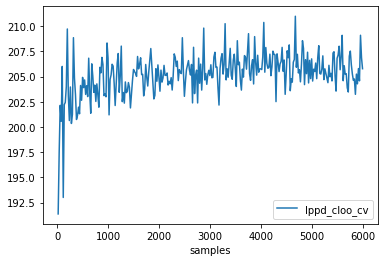

In [734]:
res.plot(x='samples', y='lppd_cloo_cv')

<AxesSubplot:xlabel='samples'>

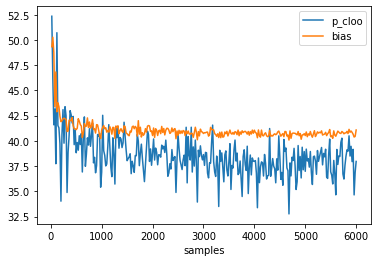

In [665]:
res[['samples', 'p_cloo', 'bias']].plot(x='samples')

In [667]:
res.to_csv('10-fold-loo.csv')

<AxesSubplot:xlabel='samples'>

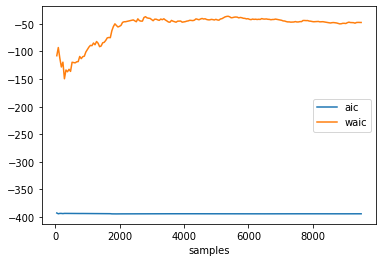

In [588]:
res.plot(x='samples')

In [20]:
samples = 1000
# Initialize models
m1 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
m2 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive')
m3 = fbprophet.Prophet(mcmc_samples=samples, seasonality_mode='additive', seasonality_prior_scale=1)
m4 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=20, seasonality_mode='additive', seasonality_prior_scale=1)
m5 = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=False, n_changepoints=1, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)

for r in ['temperature', 'fuel_price', 'cpi', 'unemployment_interpolated', 'IsHoliday']:
    m2.add_regressor(r)
    
m3.add_regressor('overfit', standardize=False, prior_scale=10)
m5.add_regressor('overfit', standardize=False, prior_scale=10) # Ei vaikutusta

Importing plotly failed. Interactive plots will not work.


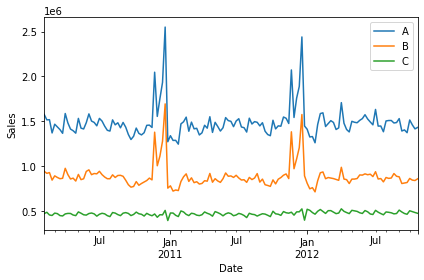

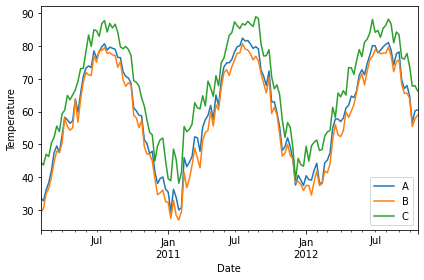

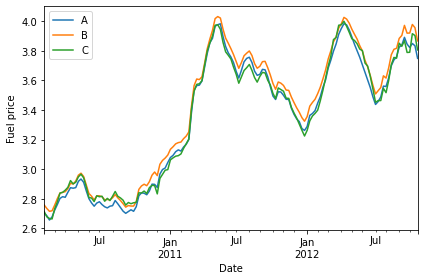

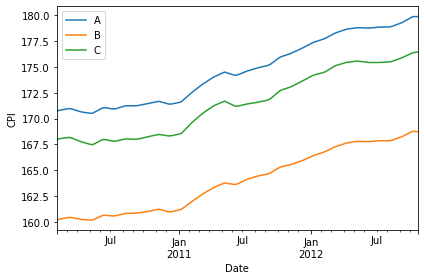

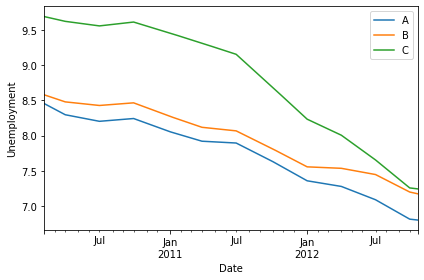

In [726]:
features = ['y', 'temperature', 'fuel_price', 'cpi', 'unemployment_interpolated']
plot_names = {'y':'Sales', 'temperature':'Temperature', 'fuel_price':'Fuel price', 'cpi':'CPI', 'unemployment_interpolated':'Unemployment'}
for f in features:
    ax = plt.subplot()
    for key in datasets.keys():
        datasets[key].plot(x='ds', y=f, ax=ax)
    ax.legend(datasets.keys())
    ax.set_ylabel(plot_names[f])
    ax.set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'plots/dataset_plot_{f}.eps', format='eps')
    plt.show()

In [ ]:
ax.set_ylabel()

In [672]:
datasets['A']

,ds,temperature,fuel_price,cpi,unemployment_interpolated,y,overfit
0,2010-02-05,33.690032,2.703840,170.722140,8.453469,1.576715e+06,0.618009
1,2010-02-12,32.856791,2.685976,170.819624,8.433678,1.516366e+06,0.593377
2,2010-02-19,36.120051,2.657191,170.866465,8.413886,1.518252e+06,0.594114
3,2010-02-26,38.431706,2.678402,170.904866,8.394094,1.370861e+06,0.538734
4,2010-03-05,42.054062,2.724567,170.943267,8.374303,1.468024e+06,0.572834
...,...,...,...,...,...,...,...
138,2012-09-28,67.947303,3.845498,179.599142,6.835551,1.373897e+06,0.540572
139,2012-10-05,64.778709,3.822979,179.737298,6.814390,1.515141e+06,0.591364
140,2012-10-12,56.607945,3.849897,179.875454,6.810223,1.460697e+06,0.571143
141,2012-10-19,60.217018,3.834338,179.892947,6.806056,1.416175e+06,0.555929


In [416]:
{metric:list(v.values())[0] for metric, v in res.items()}

{'aic': -384.8779188537933,
 'dic': -432.1390722343087,
 'waic': -7.837502984999105}

In [249]:
m5_test = fbprophet.Prophet(mcmc_samples=samples, yearly_seasonality=False, n_changepoints=1, seasonality_prior_scale=0.1, changepoint_prior_scale=0.05)
m5_test.add_regressor('overfit', standardize=False, prior_scale=10)

In [363]:
m2.params['beta'][:, 0]

array([0.0094434 , 0.01300863, 0.00583609, ..., 0.00599727, 0.00823658,
       0.02280184])

In [444]:
(np.linspace(0, 1, 30)**2 * 49500 + 500).astype(int)

array([  500,   558,   735,  1029,  1441,  1971,  2618,  3384,  4266,
        5267,  6385,  7621,  8975, 10447, 12036, 13743, 15567, 17510,
       19570, 21747, 24043, 26456, 28987, 31636, 34402, 37286, 40288,
       43407, 46645, 50000])

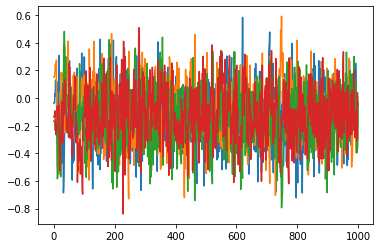

In [405]:
plt.plot(m2.stan_backend.stan_fit.extract(pars='k', inc_warmup=True, permuted=False)['k'])

In [161]:
used_models = [m4]

In [21]:
used_models = [m1, m2, m3]

In [169]:
used_models = [m1, m2, m3, m4, m5]

In [23]:
%time
res_A = compare_models(used_models, format_for_prophet(data[data['Store']==1]), metrics = {'aic':aic, 'dic':dic, 'waic':waic})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Evaluating aic
-383.48890505742895
-374.64525897292805
-823.0727781435447

Evaluating dic
-430.6573741143773
-423.83272140082767
-869.9053211652667

Evaluating waic
-284.40421525423085
-170.33334001739348
-852.8847653701401



In [23]:
res_A

{'aic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0dcf3d0>: -383.8689301608247,
  <prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0dcf250>: -375.09797970554183,
  <prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0d55790>: -838.4562553597839},
 'dic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0dcf3d0>: -431.0625529757168,
  <prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0dcf250>: -425.0732584677379,
  <prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0d55790>: -885.2947651062192},
 'waic': {<prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0dcf3d0>: -285.23479597906135,
  <prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0dcf250>: -190.02866711883837,
  <prophet.python.fbprophet.forecaster.Prophet at 0x7fd6f0d55790>: -857.2193973790874}}

In [24]:
from prophet.python.fbprophet import diagnostics

In [27]:
147 - 52*2

43

In [30]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [37]:
def defalut_cross_val(model, horizon='15w', initial='104w'):
    cv_res = diagnostics.cross_validation(model, horizon=horizon, initial=initial)
    agg = diagnostics.performance_metrics(cv_res, rolling_window=1)
    return {'aggregated':agg, 'preds':cv_res}

In [24]:
cv_res = diagnostics.cross_validation(used_models[0], horizon='20w', initial='104w')

INFO:fbprophet:Making 2 forecasts with cutoffs between 2012-03-30 00:00:00 and 2012-06-08 00:00:00


In [25]:
cv_res

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-04-06,1.621122e+06,1.441652e+06,1.813215e+06,1899676.88,2012-03-30
1,2012-04-13,1.631650e+06,1.447258e+06,1.824245e+06,1621031.70,2012-03-30
2,2012-04-20,1.630990e+06,1.444871e+06,1.824670e+06,1521577.87,2012-03-30
3,2012-04-27,1.616698e+06,1.418908e+06,1.807659e+06,1468928.37,2012-03-30
4,2012-05-04,1.603882e+06,1.419272e+06,1.797284e+06,1684519.99,2012-03-30
5,2012-05-11,1.605286e+06,1.402409e+06,1.784716e+06,1611096.05,2012-03-30
6,2012-05-18,1.616510e+06,1.425346e+06,1.813871e+06,1595901.87,2012-03-30
7,2012-05-25,1.625348e+06,1.437994e+06,1.812714e+06,1555444.55,2012-03-30
8,2012-06-01,1.629205e+06,1.439235e+06,1.823123e+06,1624477.58,2012-03-30
9,2012-06-08,1.634764e+06,1.436741e+06,1.827167e+06,1697230.96,2012-03-30


In [26]:
from prophet.python.fbprophet import plot as fbplot

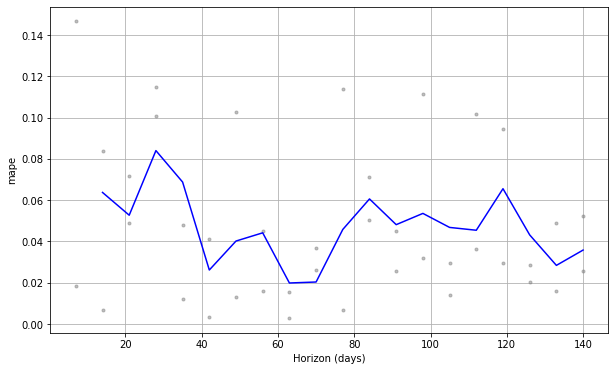

In [28]:
fbplot.plot_cross_validation_metric(cv_res, 'mape');

In [33]:
diagnostics.performance_metrics(cv_res, rolling_window=1)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,140 days,9.515632e+09,97548.102728,75600.843259,0.047712,0.036667,0.925


In [211]:
m5_test.params['beta'].mean(axis=0)

array([0.99969518])

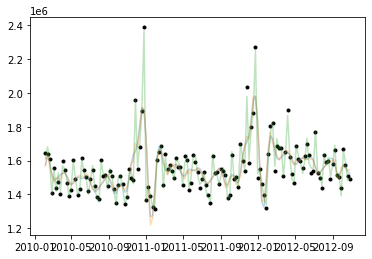

In [770]:
ax = plt.subplot()
#ax2 = plt.subplot()
t = used_models[0].history['ds'].dt.to_pydatetime()
ax.plot(t, used_models[0].history['y'], 'k.')
for m in used_models:
    fc = m.predict()
    ax.plot(t, fc['yhat'], ls='-', alpha=0.3)

<AxesSubplot:xlabel='ds'>

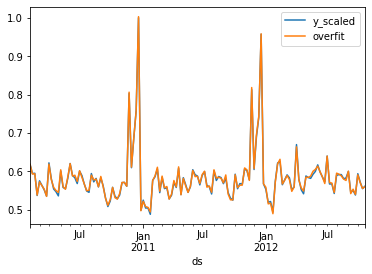

In [740]:

ax = m1.history.plot(x='ds', y='y_scaled')
m5_test.history.plot(x='ds', y='overfit', ax=ax)

In [173]:
m5.history['y_scaled'].mean()

0.5828448647174851

In [174]:
m5.history['overfit'].mean()

0.5876918005062771

In [194]:
(m5.history['overfit'] - m5.history['y_scaled']).mean()

0.0048469357887920925

In [204]:
(m5.params['m'][:, np.newaxis] / m5.history['y_scaled'].values[np.newaxis, :]).mean()

0.09185084611800698

In [181]:
res = compare_models([m1, m2], format_for_prophet(data[data['Store']==2]), no_fit=True, metrics = {'10-fold-cv':lambda x: k_fold_loo_cv(x, k=10)})

Evaluating 10-fold-cv
Done
Done



In [253]:
result_df = pd.DataFrame(index=used_models)

In [254]:
for metric_name, values in res_A.items():
    for model, value in values.items():
        if type(value) == dict:
            cols = [c for c in value.keys() if c != 'fitted_params']
            for c in cols:
                result_df.loc[model, f'{metric_name}_{c}'] = value[c]
        else:
            result_df.loc[model, metric_name] = value
result_df = result_df.rename(index={m1:'m1', m2:'m2', m3:'m3', m4:'m4', m5:'m5'})

In [255]:
result_df

,aic,dic,waic,10-fold-cv_lppd_loo_cv,10-fold-cv_lppd_cloo_cv,10-fold-cv_bias,10-fold-cv_p_cloo
m1,-393.273233,-438.295551,-47.288752,211.248997,213.860186,2.611189,29.776430
m2,-386.108843,-433.483779,-5.772069,206.478646,208.540084,2.061438,35.514337
m3,-594.846456,-641.922596,-575.860533,306.996194,311.499716,4.503522,33.923512
m4,-456.019854,-511.907067,-31.473996,141.942643,151.167944,9.225301,143.841983
m5,-650.773633,-649.487336,-649.512305,323.798699,324.968025,1.169326,4.418791


In [265]:
import arviz

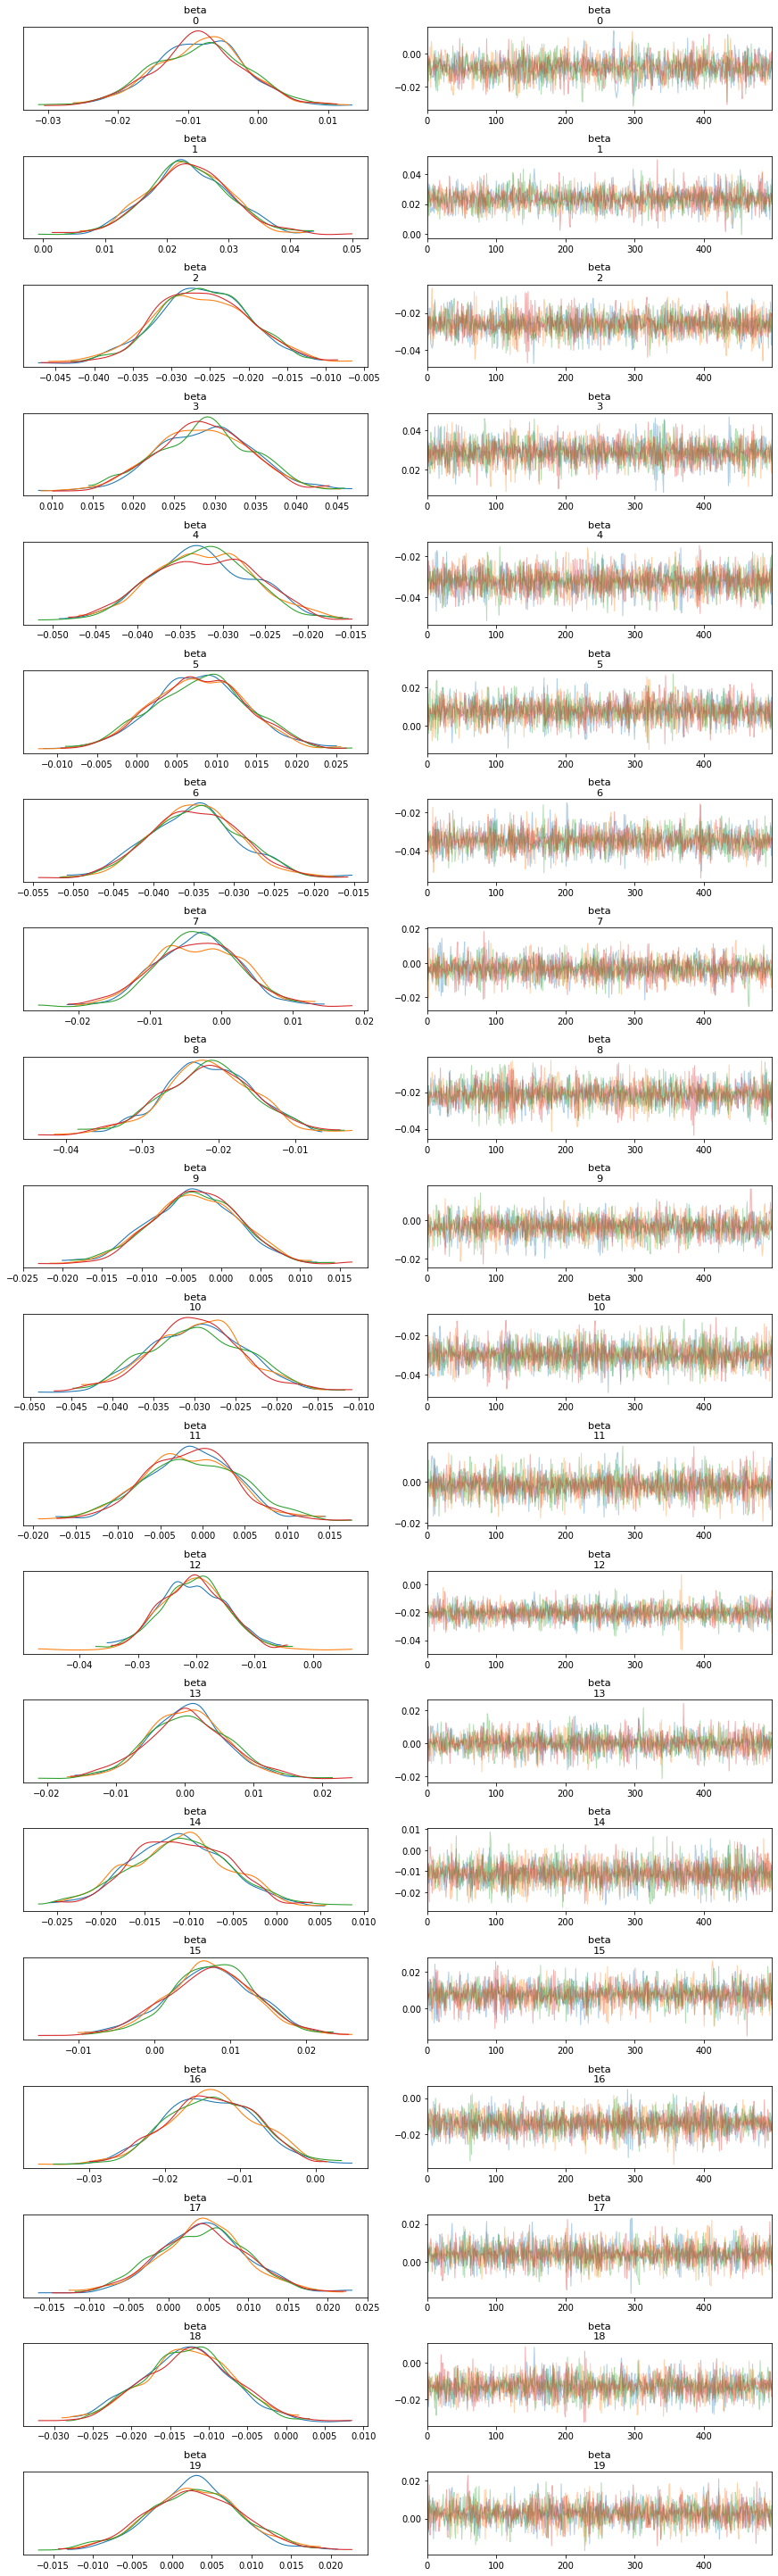

In [268]:
arviz.plot_trace(m1.stan_backend.stan_fit, var_names='beta');

In [314]:
kmean = m5.params['k'].mean()
mmean = m5.params['m'].mean()
deltamean = m5.params['delta'].mean()
sigmamean = m5.params['sigma_obs'].mean()
betamean = m5.params['beta'].mean()

In [357]:
d = 0.1
xvals = np.linspace(betamean - d + 0.1, betamean + d + 0.1, num=40)
yvals = np.linspace(mmean - d, mmean + d, num=40)

In [358]:
values = pd.concat([pd.Series({'x': x, 'y':y, 'value':m5.stan_backend.stan_fit.log_prob(upar=[kmean, y, deltamean, sigmamean, x])}) for x in xvals for y in yvals], axis=1).T

<AxesSubplot:xlabel='y', ylabel='x'>

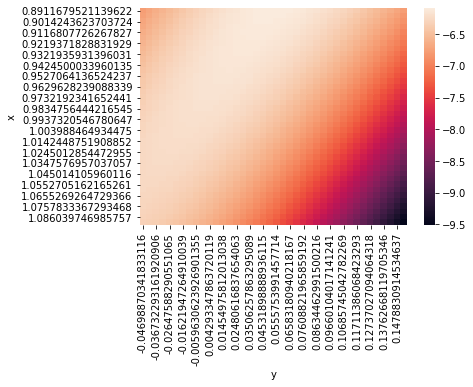

In [359]:
sns.heatmap(values.pivot(index='x', columns='y', values='value'))

In [285]:
m5.stan_backend.stan_fit.log_prob(upar=[0, 0, 0, 0.03, 1])

-6.9292482250305385

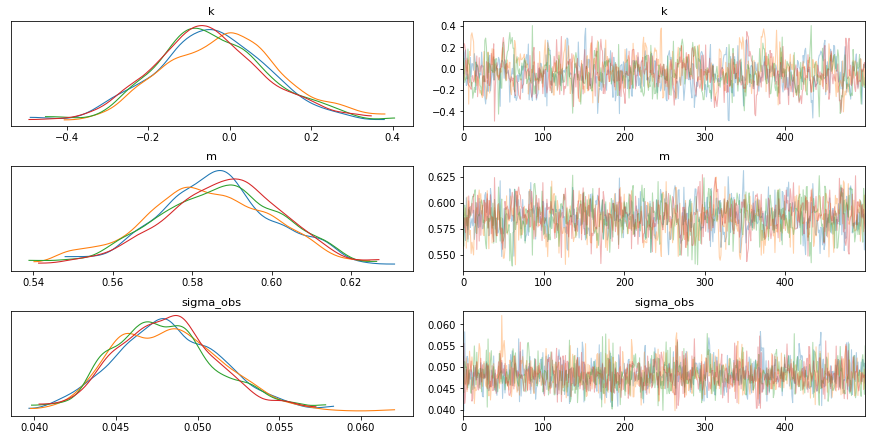

In [116]:
arviz.plot_trace(m1.stan_backend.stan_fit, var_names=['k', 'm', 'sigma_obs']);